In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%reload_ext autoreload
%autoreload 2
sns.set(color_codes=True)

# Introduction to question 1

In this home work, we will work with a by-now classic dataset from Robert LaLonde's study "_Evaluating the Econometric Evaluations of Training Programs" (1986)_. The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program. Our task is to determine the effectiveness of the "treatment" represented by the job training program analysing the features and outcomes of the experiment.


In [2]:
#Importation of the dataset
df_lalonde = pd.read_csv('lalonde.csv').set_index('id')
#First look at the dataset
df_lalonde.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [3]:
#Second look at the dataset considering basics statistics on it
df_lalonde.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


# Question 1: Propensity score matching

In this exercise, we will apply propensity score matching, in order to draw conclusions from an observational study, which is by definition (from the book on the _"Design of Observational Studies"_ ): “an empiric investigation of effects caused by treatments when randomized experimentation is unethical or infeasible.”

### 1. A naive analysis

We will first take a look at the distribution of the feature re78 within the two groups :
* The first group is the “treated” one which received the job training program.
* The second one the control group : is a group of subject resembling the “treatment” group in many demographic variables but not receiving “the treatment” (in this case the formation) under study and thereby serving as a comparison group when treatment results are evaluated


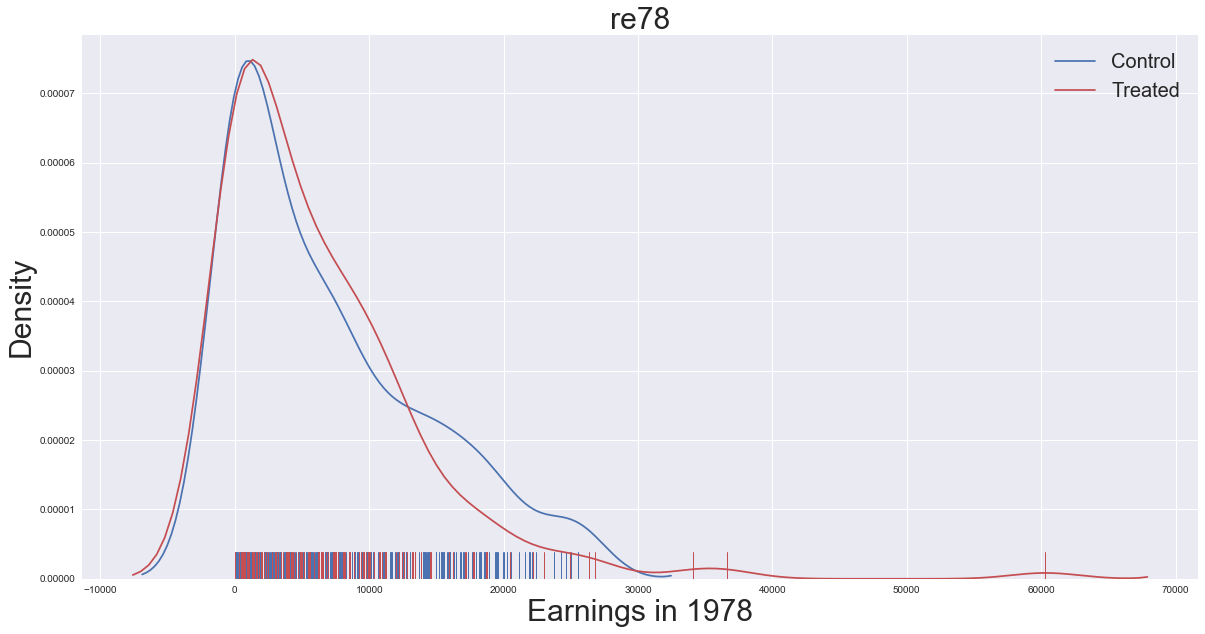

In [4]:
#Separation of the groups according to their label in the dataset
df_lalonde_treated = df_lalonde[df_lalonde.treat == 1]
df_lalonde_control = df_lalonde[df_lalonde.treat == 0]

#Plot of the distribution of the two groups : 
#The rug parameter set to "True" is used to draw small vertical lines to show each observation in a distribution. 
#The choice of this parameter, is to have a better interpretation of the samples distribution according to their intensity
plt.figure(figsize=(20,10))
sns.distplot(df_lalonde_control["re78"], color='b', hist=False, rug=True, label="Control").set_title('re78', fontsize=30)
sns.distplot(df_lalonde_treated["re78"], color='r', hist=False, rug=True, label="Treated")
plt.legend(prop={'size': 20})
plt.xlabel('Earnings in 1978', fontsize=30)
plt.ylabel('Density', fontsize=30)
plt.show()

We can see on this distplot that the density of treated and control groups are equivalent until 5000 of earnings. However, we distinghusih that the density gets higher for the treated group until 12000 and then the trend is reversed.

By looking at the data a  naive "researcher" might conclude that people who took part in the job training might not increase their earnings or even worsen them. On the other hand, the data shows that there might be some treated person becoming more susceptible to earn a large amount of money in 1778 after the training. Indeed we only have extreme salaries in the treated group.

It becomes even clearer when looking at the statistics of the distribution below or the boxplot.

In [5]:
#Description of both groups
df_summary = pd.DataFrame()
df_summary["treated"] = df_lalonde_treated["re78"].describe()
df_summary["control"] = df_lalonde_control["re78"].describe()
df_summary

,treated,control
count,185.000000,429.000000
mean,6349.143530,6984.169742
std,7867.402218,7294.161791
min,0.000000,0.000000
25%,485.229800,220.181300
50%,4232.309000,4975.505000
75%,9642.999000,11688.820000
max,60307.930000,25564.670000


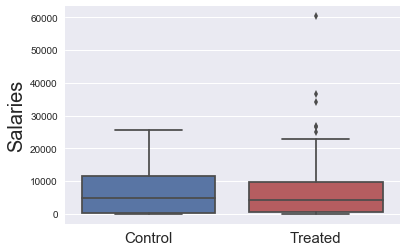

In [58]:
#Boxplot in order to visualize the mean, standard deviation and outsiders
box = sns.boxplot(x="treat", y="re78", data=df_lalonde, palette = ["b","r"])
box.set_xticklabels(['Control', 'Treated'], fontsize=15)
box.set_xlabel('')
box.set_ylabel('Salaries', fontsize=20)
plt.show()

Unfortunately this naive approach makes a supeficial analyisis, and therefore, to enhance our trust into the comparison, we will investigate the observed variables among each group.

### 2. A closer look at the data

As the risk of bias is present in observational study, we cannot build strong conclusion yet. We thus need to go deeper in our analysis.
For each feature in the dataset, we highlight the differnece in distributions among the treated and control group.

This will help us to distinguish irregularities in their density when comparing the two groups.

In [7]:
#We insert one column that represents the "white race" in order to plot its distribution next to the two other "races"
df_lalonde["white"] = (df_lalonde["black"] + df_lalonde["hispan"] + 1)%2

In [8]:
#Reorder the columns name so that we don't have the white feaure at the end of the dataset
cols = ['treat','age','educ','black','hispan','white','married','nodegree','re74','re75','re78']
df_lalonde = df_lalonde[cols]

In [9]:
#In order to optimize the notebook space, we decided to create some functions, that will plot the needed graphs 
#according to the type of the feature (categorical or not) as a barplot seems to be more suited for a categorical feature.

def is_categoric(feature):
    """Return true if the feature passed in argument is of type categorical"""
    return feature in ['black', 'hispan','white', 'married', 'nodegree']

def compare_feature(df,feature, ax=None):
    """Return a description of the feature conditioned on the treatement and plot
    the distribution of the data for the treatment and the control groups"""
    df_treated = df[df.treat == 1]
    df_control = df[df.treat == 0]
    plt.tight_layout()
    if is_categoric(feature):
        #plot a bar plot
        sns.barplot(df['treat'], df[feature], palette=['b', 'r'], saturation=0.6, ax=ax)
        ax.set_xticklabels(['Control', 'Treated'], fontsize=15)
        ax.set_xlabel('')
        ax.set_ylabel('Ratio of '+feature, fontsize=20)
    else:
        sns.distplot(df_control[feature], color='b', label="Control", ax=ax)
        sns.distplot(df_treated[feature], color='r', label="Treated", ax=ax)
        ax.set_ylabel('Density', fontsize=20)
    ax.legend()
    ax.xaxis.label.set_size(20)
    df_summary = pd.DataFrame()
    df_summary[(feature, "treated")] = df_treated[feature].describe()
    df_summary[(feature, "control")] = df_control[feature].describe()
    df_summary.columns = pd.MultiIndex.from_tuples([(feature,'treated'),(feature,'control')], names=['feature', 'treat'])
    return df_summary

def get_features(df):
    """Return the features of the dataframe under the form of a list whitout "treat" """
    features = list(df.columns)
    features.remove('treat')
    return features

def compare_all_feature(df):
    """Return the comparisons of the features as well as their respective plots"""
    df_all_summary = pd.DataFrame()
    features = get_features(df)
    nb_col = 2
    nb_row = int(np.ceil(len(features)/nb_col))
    print(f'rows: {nb_row} & cols: {nb_col} for nb_feature: {len(features)}')
    fig, axes = plt.subplots(nb_row,nb_col, figsize=(15,20))
    for i, f in enumerate(features):
        x = int(i/nb_col)
        y = i%nb_col
        df_temp = compare_feature(df, f, axes[x, y])
        df_all_summary = pd.concat([df_all_summary, df_temp], axis=1)
    
    return df_all_summary

rows: 5 & cols: 2 for nb_feature: 10


feature         age                    educ                   black  \
treat       treated     control     treated     control     treated   
count    185.000000  429.000000  185.000000  429.000000  185.000000   
mean      25.816216   28.030303   10.345946   10.235431    0.843243   
std        7.155019   10.786653    2.010650    2.855238    0.364558   
min       17.000000   16.000000    4.000000    0.000000    0.000000   
25%       20.000000   19.000000    9.000000    9.000000    1.000000   
50%       25.000000   25.000000   11.000000   11.000000    1.000000   
75%       29.000000   35.000000   12.000000   12.000000    1.000000   
max       48.000000   55.000000   16.000000   18.000000    1.000000   

feature                  hispan                   white              \
treat       control     treated     control     treated     control   
count    429.000000  185.000000  429.000000  185.000000  429.000000   
mean       0.202797    0.059459    0.142191    0.097297    0.655012   
std        0.402552    0.237124    0.349654    0.297166    0.475919   
min        0.000000    0.000000    0.000000    0.000000    0.000000   
25%        0.000000    0.000000    0.000000    0.000000    0.000000   
50%        0.000000    0.000000    0.000000    0.000000    1.000000   
75%        0.000000    0.000000    0.000000    0.000000    1.000000   
max        1.000000    1.000000    1.000000    1.000000    1.000000   

feature     married                nodegree                      re74  \
treat       treated     control     treated     control       treated   
count    185.000000  429.000000  185.000000  429.000000    185.000000   
mean       0.189189    0.512821    0.708108    0.596737   2095.573689   
std        0.392722    0.500419    0.455867    0.491126   4886.620353   
min        0.000000    0.000000    0.000000    0.000000      0.000000   
25%        0.000000    0.000000    0.000000    0.000000      0.000000   
50%        0.000000    1.000000    1.000000    1.000000      0.000000   
75%        0.000000    1.000000    1.000000    1.000000   1291.468000   
max        1.000000    1.000000    1.000000    1.000000  35040.070000   

feature                        re75                        re78                
treat         control       treated       control       treated       control  
count      429.000000    185.000000    429.000000    185.000000    429.000000  
mean      5619.236506   1532.055314   2466.484443   6349.143530   6984.169742  
std       6788.750796   3219.250870   3291.996183   7867.402218   7294.161791  
min          0.000000      0.000000      0.000000      0.000000      0.000000  
25%          0.000000      0.000000      0.000000    485.229800    220.181300  
50%       2547.047000      0.000000   1086.726000   4232.309000   4975.505000  
75%       9277.128000   1817.284000   3881.419000   9642.999000  11688.820000  
max      25862.320000  25142.240000  18347.230000  60307.930000  25564.670000

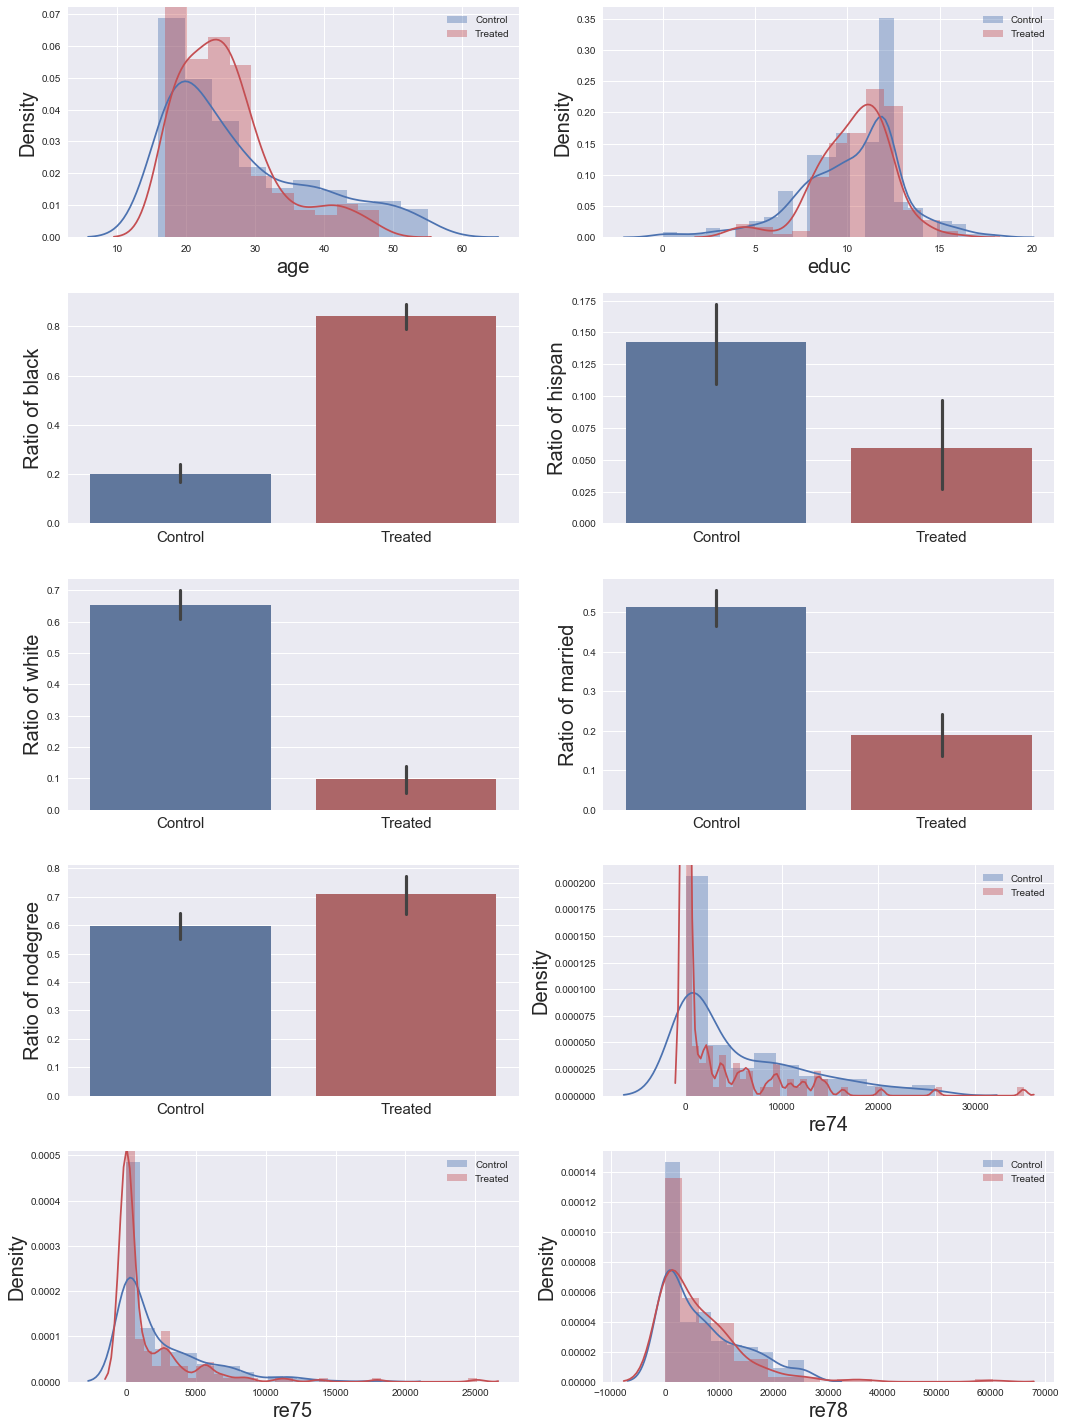

In [10]:
compare_all_feature(df_lalonde)

We can clearly see on the different plots that many features are unbalanced with respect to control and treated group.

Indeed, if we take, as example, the proportion of married people, we can see that it is a lot higher for the control group than for those who are treated. In other words, being married could influence a lot the fact that someone is treated or not and therefore, comparing a control group which has a much higher density of married people to the treated group may result in a biased interpreation of the analysis. 

A possible solution would be to find a way to compare only indivduals that are sufficientely similar and being part of distinct groups.
Using a propensity score we will be able to compare more reliably the two groups

### 3. A propensity score model

Definition : A propensity score is the probability of a unit (person) "x" being assigned to a particular treatment given a set of observed covariates as : 
* $ p(x) = Pr(treat = 1 | X = x) $

Propensity scores are used to reduce selection bias by equating groups based on these covariates.

To implement such a propensity score, we will use logistic regression that we want to overfit as much as possible. To do so, we increased the max_iter parameter, and chose the l1 penality which gives use a slightly better score on the training set.

In [11]:
from sklearn import linear_model
logistic = linear_model.LogisticRegression()

In [12]:
# Finding the probability of people that received the treatement given the covariate (features) 
# We don't need anymore the "white" feature used for the plot as its information is conained in the black and hispan features
df_lalonde = df_lalonde.drop('white', 1)
X = df_lalonde[get_features(df_lalonde)]
y = df_lalonde['treat']
logistic.fit(X, y)
df_lalonde['propensity'] = logistic.predict_proba(X)[:,1]
print(f'The logistic regression score : {logistic.score(X, y)}')
df_lalonde.head()

The logistic regression score : 0.8045602605863192


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.458074
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.151980
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.750966
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.674020
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.670590


### 4. Balancing the dataset via matching
Now we will use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
Our matching should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

In [13]:
from scipy.optimize import linear_sum_assignment

In [14]:
def create_cost_matrix(treated, control):
    """ Return the cost matrix between the two arrays
        Each entry (i,j) in the cost matrix represent the distance from 
        node i to node j"""
    cost = np.zeros([len(treated), len(control)])
    for i, t in enumerate(treated):
        for j, c in enumerate(control):
            cost[i, j] = abs(t-c)
    return cost

def propensity_matching(df):
    """Return the treated and a subset of control composed from the 
    one matching between the closest point in the control dataset"""
    df_treated = df[df['treat']==1]
    df_control = df[df['treat']==0]
    cost_matrix = create_cost_matrix(df_treated['propensity'], df_control['propensity'])

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    return pd.concat([df_treated, df_control.iloc[col_ind]])

In [15]:
df_balanced  = propensity_matching(df_lalonde)

rows: 5 & cols: 2 for nb_feature: 10


feature         age                    educ                   black  \
treat       treated     control     treated     control     treated   
count    185.000000  185.000000  185.000000  185.000000  185.000000   
mean      25.816216   23.167568   10.345946    9.864865    0.843243   
std        7.155019    9.337805    2.010650    2.775692    0.364558   
min       17.000000   16.000000    4.000000    0.000000    0.000000   
25%       20.000000   17.000000    9.000000    8.000000    1.000000   
50%       25.000000   19.000000   11.000000   10.000000    1.000000   
75%       29.000000   24.000000   12.000000   12.000000    1.000000   
max       48.000000   55.000000   16.000000   17.000000    1.000000   

feature                 hispan                 married              \
treat      control     treated     control     treated     control   
count    185.00000  185.000000  185.000000  185.000000  185.000000   
mean       0.47027    0.059459    0.102703    0.189189    0.183784   
std        0.50047    0.237124    0.304394    0.392722    0.388359   
min        0.00000    0.000000    0.000000    0.000000    0.000000   
25%        0.00000    0.000000    0.000000    0.000000    0.000000   
50%        0.00000    0.000000    0.000000    0.000000    0.000000   
75%        1.00000    0.000000    0.000000    0.000000    0.000000   
max        1.00000    1.000000    1.000000    1.000000    1.000000   

feature    nodegree                      re74                        re75  \
treat       treated     control       treated       control       treated   
count    185.000000  185.000000    185.000000    185.000000    185.000000   
mean       0.708108    0.675676   2095.573689   2268.386180   1532.055314   
std        0.455867    0.469392   4886.620353   4266.737051   3219.250870   
min        0.000000    0.000000      0.000000      0.000000      0.000000   
25%        0.000000    0.000000      0.000000      0.000000      0.000000   
50%        1.000000    1.000000      0.000000    336.993900      0.000000   
75%        1.000000    1.000000   1291.468000   2217.890000   1817.284000   
max        1.000000    1.000000  35040.070000  21918.320000  25142.240000   

feature                        re78                propensity              
treat         control       treated       control     treated     control  
count      185.000000    185.000000    185.000000  185.000000  185.000000  
mean      1670.138671   6349.143530   5828.584903    0.555453    0.377476  
std       2734.930726   7867.402218   6094.306306    0.206467    0.234568  
min          0.000000      0.000000      0.000000    0.036175    0.036219  
25%          0.000000    485.229800    237.914000    0.451977    0.183745  
50%        470.854800   4232.309000   4112.513000    0.647735    0.239343  
75%       1976.516000   9642.999000   8957.978000    0.695839    0.650508  
max      13776.530000  60307.930000  25564.670000    0.885622    0.792162

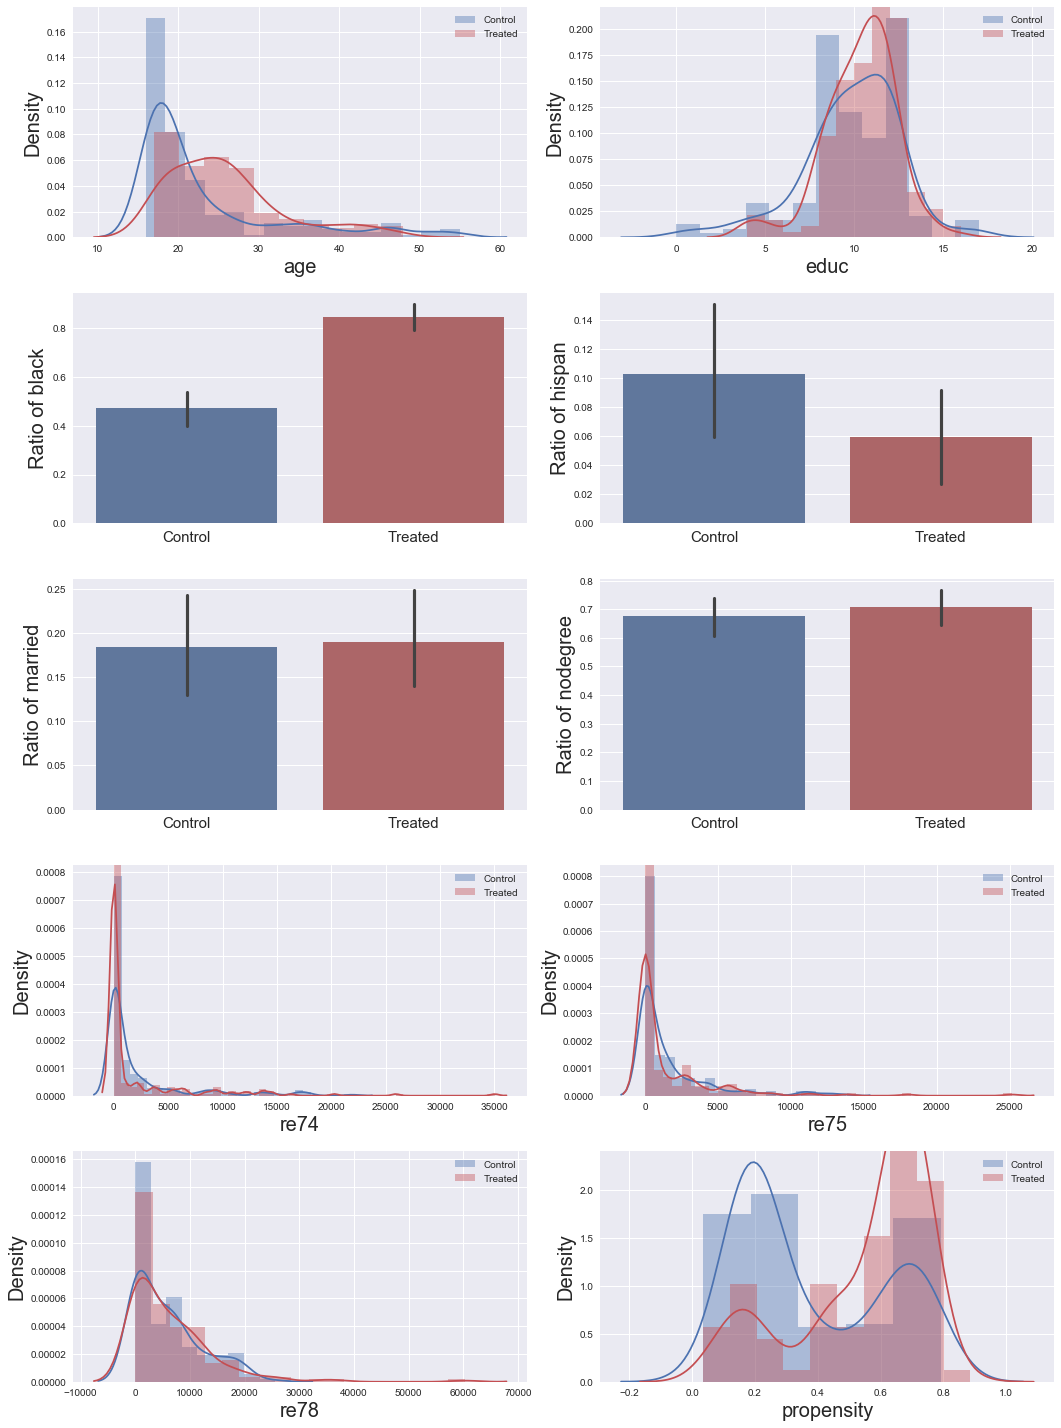

In [16]:
compare_all_feature(df_balanced)

We can now see that the distribution among the different features is more similar than before. When looking at the barplots, we see that the control and treated group are better balanced with respect to the corresponding feature.

However, we still don't have sufficiently close matches. This is due to the fact that there are not enough similar persons in the control group to be acceptably matched with a person from the treated group. Indeed, since we chose to make up pairs which minimizes the abslute difference of propensitiy scores among all pairs, we cannot guarantee that all pairs will have close propensity scores.

We can be convinced by that when looking at all the matched pairs. For example the following pair:

In [17]:
i=3
df_balanced.iloc[[i, i+185]]

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
id,,,,,,,,,,,
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.146,0.674020
PSID425,0,18,11,0,0,0,1,0.0,0.0,10150.500,0.201542


NSW4 and PSID425 have been matched together but aren't similar at all.

### 5. Balancing the groups further
If there isn't any good enough matching for some point in the treated set to the control set then it is imposible to do better

We can for each pair decide if we keep it based on this decision : $ | p_t - p_c | < \epsilon $ Then based on this decision keep only the treated point and rerun the algorithm to find if we can find even closer control point that the one that was initaly maped

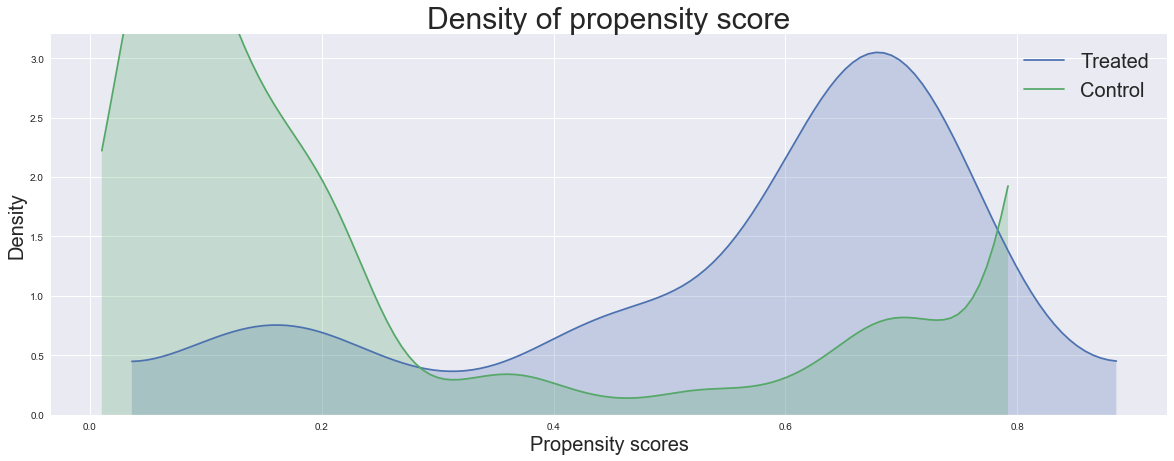

In [67]:
#Below we use a cut = 0 in order to lower bound our datapoints used to fit KDE.
plt.figure(figsize=(20,7))
sns.kdeplot(df_lalonde[df_lalonde.treat==1]['propensity'], shade=True, label='Treated', cut=0).set_title('Density of propensity score', fontsize=30)
sns.kdeplot(df_lalonde[df_lalonde.treat==0]['propensity'], shade=True, label='Control', cut=0)
plt.legend(prop={'size': 20})
plt.xlabel('Propensity scores', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.show()

In [20]:
def extended_matching(df, treshold, rematch=False):
    """Returns a new Dataframe with treated and control groups whose propensity score
    don't differ more than a given treshold. If rematch"""    
    df_temp = df
    iteration = 1
    if rematch:
        iteration = 2
    for i in range(0, iteration):
        df_prop = propensity_matching(df_temp)
        df_treated = df_prop[df_prop.treat == 1].reset_index()
        df_control = df_prop[df_prop.treat == 0].reset_index()
        
        indexes = df_treated[np.abs(df_treated.propensity - df_control.propensity) < treshold].index
        df_temp = pd.concat([df_treated.iloc[indexes].set_index('id'), df[df.treat == 0]])
        
    df_balanced_corr = pd.concat([df_prop.iloc[indexes], df_prop.iloc[indexes + len(df_treated)]])
       
    return df_balanced_corr


In [21]:
df_new_balanced = extended_matching(df_lalonde, 0.1, False)

rows: 5 & cols: 2 for nb_feature: 10


feature        age                  educ                 black             \
treat      treated    control    treated    control    treated    control   
count    97.000000  97.000000  97.000000  97.000000  97.000000  97.000000   
mean     24.814433  23.144330  10.164948  10.175258   0.701031   0.680412   
std       6.583328   8.897553   2.139317   2.711896   0.460184   0.468739   
min      17.000000  16.000000   4.000000   1.000000   0.000000   0.000000   
25%      19.000000  18.000000   9.000000   9.000000   0.000000   0.000000   
50%      25.000000  19.000000  11.000000  11.000000   1.000000   1.000000   
75%      27.000000  24.000000  12.000000  12.000000   1.000000   1.000000   
max      48.000000  55.000000  14.000000  17.000000   1.000000   1.000000   

feature     hispan               married              nodegree             \
treat      treated    control    treated    control    treated    control   
count    97.000000  97.000000  97.000000  97.000000  97.000000  97.000000   
mean      0.113402   0.061856   0.175258   0.164948   0.690722   0.608247   
std       0.318731   0.242145   0.382162   0.373062   0.464597   0.490678   
min       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%       0.000000   0.000000   0.000000   0.000000   1.000000   1.000000   
75%       0.000000   0.000000   0.000000   0.000000   1.000000   1.000000   
max       1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   

feature          re74                        re75                        re78  \
treat         treated       control       treated       control       treated   
count       97.000000     97.000000     97.000000     97.000000     97.000000   
mean      2293.061791   2146.730295   1830.951116   1547.466179   7209.567101   
std       5652.612795   4003.114869   3749.322278   2814.802700   7606.150847   
min          0.000000      0.000000      0.000000      0.000000      0.000000   
25%          0.000000      0.000000      0.000000      0.000000    559.443200   
50%          0.000000    133.230100      0.000000    293.612900   5112.014000   
75%       1929.029000   2068.986000   2409.274000   1679.323000  11163.170000   
max      35040.070000  17925.330000  25142.240000  12756.050000  36646.950000   

feature               propensity             
treat         control    treated    control  
count       97.000000  97.000000  97.000000  
mean      5438.704191   0.499564   0.492579  
std       6188.497108   0.256217   0.255388  
min          0.000000   0.036175   0.036219  
25%         31.032260   0.204324   0.186440  
50%       3367.739000   0.643315   0.637289  
75%       7933.914000   0.720778   0.704759  
max      25564.670000   0.801630   0.792162

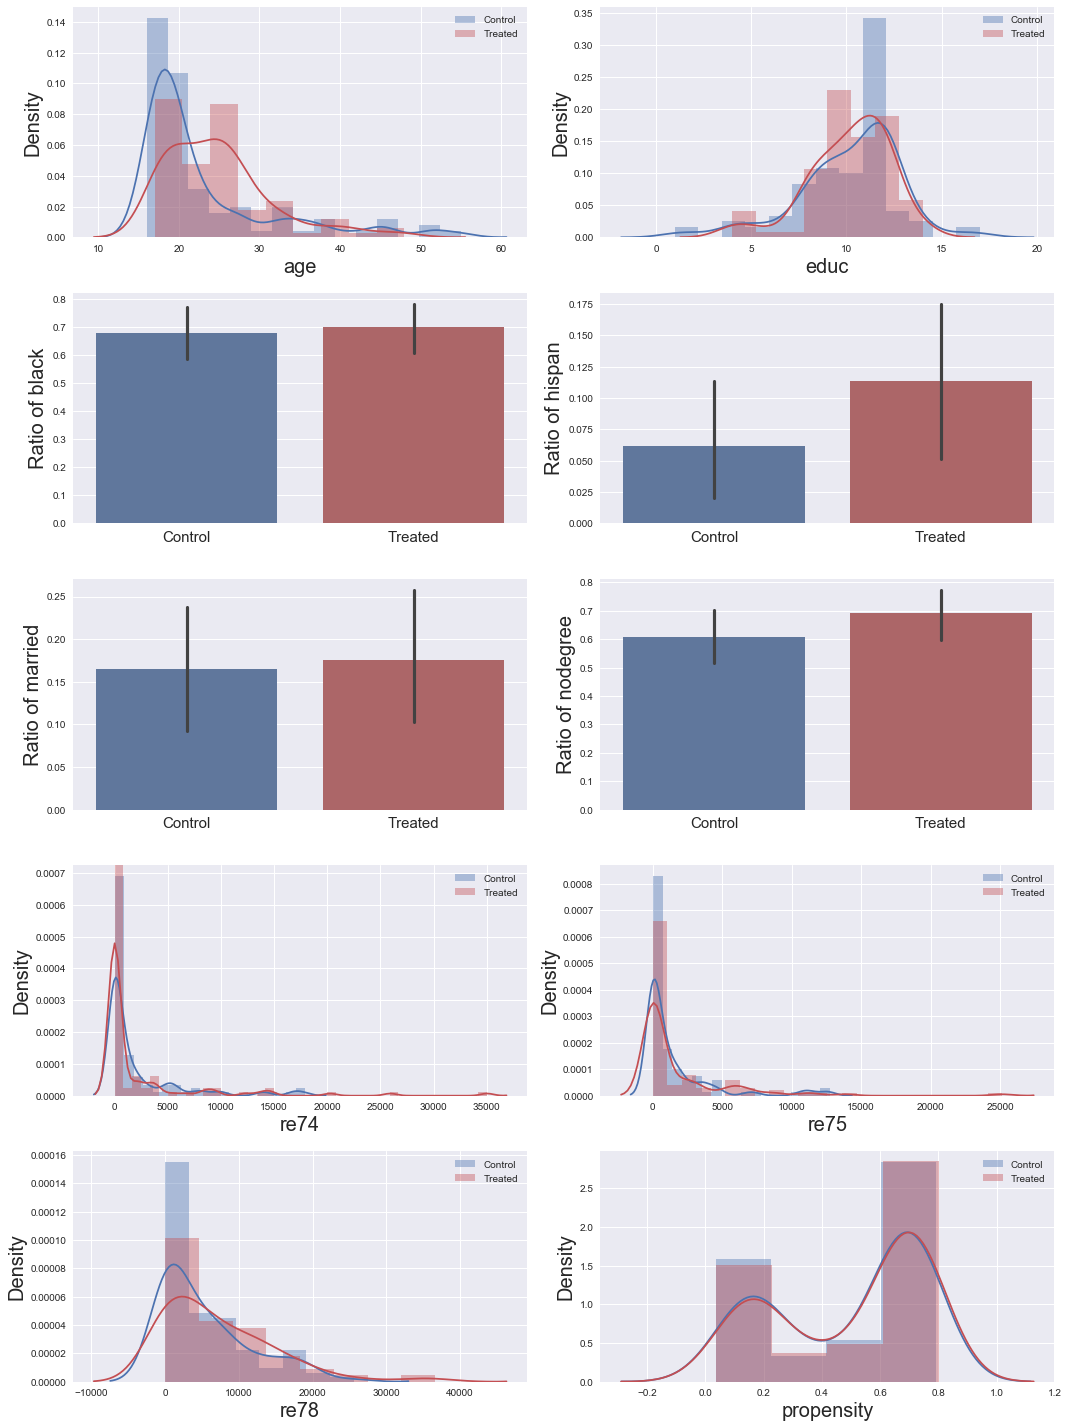

In [22]:
compare_all_feature(df_new_balanced)

### 6. A less naive analysis
Finally we will again compare the outcomes (re78) between treated and control subjects, as we've done in part 1, but now only for the matched dataset we've obtained from part 5.

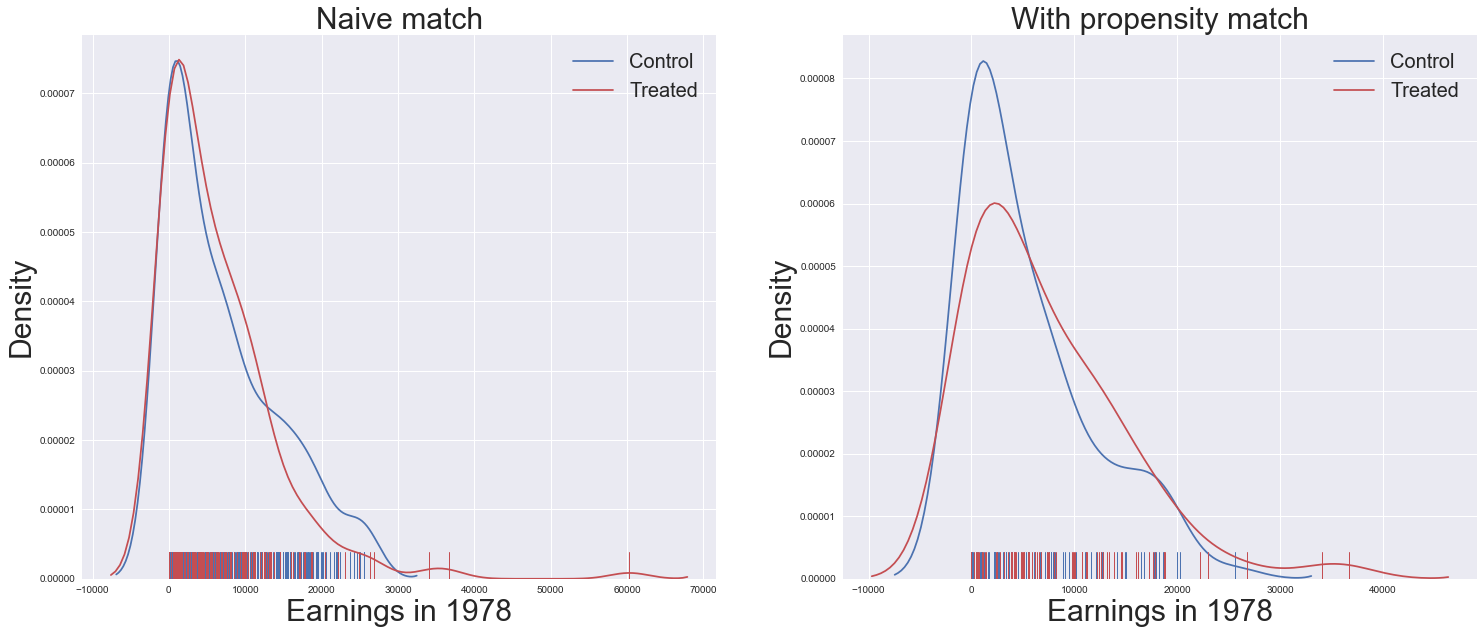

In [23]:
df_new_balanced_treated = df_new_balanced[df_new_balanced.treat == 1]
df_new_balanced_control = df_new_balanced[df_new_balanced.treat == 0]

plt.figure(figsize=(25,10))
plt.subplot(1, 2, 1)
sns.distplot(df_lalonde_control["re78"], color='b', hist=False, rug=True, label="Control").set_title('Naive match', fontsize=30)
sns.distplot(df_lalonde_treated["re78"], color='r', hist=False, rug=True, label="Treated")
plt.legend(prop={'size': 20})
plt.xlabel('Earnings in 1978', fontsize=30)
plt.ylabel('Density', fontsize=30)
plt.subplot(1, 2, 2)
sns.distplot(df_new_balanced_control["re78"], color='b', hist=False, rug=True, label="Control").set_title('With propensity match', fontsize=30)
sns.distplot(df_new_balanced_treated["re78"], color='r', hist=False, rug=True, label="Treated")
plt.legend(prop={'size': 20})
plt.xlabel('Earnings in 1978', fontsize=30)
plt.ylabel('Density', fontsize=30)
plt.show()

In [38]:
#Description of both groups in the new propensity matching method
df_prop_summary = pd.DataFrame()
df_prop_summary["treated"] = df_new_balanced_treated["re78"].describe()
df_prop_summary["control"] = df_new_balanced_control["re78"].describe()
df_prop_summary

,treated,control
count,97.000000,97.000000
mean,7209.567101,5438.704191
std,7606.150847,6188.497108
min,0.000000,0.000000
25%,559.443200,31.032260
50%,5112.014000,3367.739000
75%,11163.170000,7933.914000
max,36646.950000,25564.670000


This time, a complete different interpretation can be made with the corrected plot. While we had the assumptions that the training job didn't improve the earnings outcome first, we can now see that there is a smaller density of treated people among low salaries and has higher density all along above 7000 of earnings.

We can, therefore conclude that, indeed, the training job has a positive impact on the salaries of the treated group!

# Question 2: Applied ML
For this question we are going to build a classifier of news to directly assign them to 20 news categories. 

TODO:
- Clean the code (remove some useless cells, put funciton in a separate python file)

### 2.1.1 Loading the DataSet
We will first load the 20newsgroup dataset,which is a classic dataset that can directly be loaded using sklearn.

TODO:
- Explain our preprocessing on the text
- Find a way to map the feature with it's name (real word)
- Explain why I don't split into 3 set (but only test and train set)

In [24]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from time import time 

[Pipline](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

In [25]:
# limit the list of categories to make running this example faster.
cat = None#= ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']#['alt.atheism', 'talk.religion.misc', 'sci.space']
news_groups = fetch_20newsgroups(random_state=1, subset='train', categories=cat)

### 2.1.2 Representing our corpus into a bag of word
In order to be able to represent our data into a vector (bag of words) containing TFIDF weights we will use the Tfidfvectorizer of the sklearn library

Definitions : 
* **TF-IDF**, short for term frequency–inverse document frequency, gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF).
* The **bag-of-words** model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.
* In computing, **stop words** are words which are filtered out before or after processing of natural language data (text).
* In the fields of computational linguistics and probability, an **n-gram** is a contiguous sequence of n items from a given sequence of text or speech

In [26]:
#Here we use the Tfidfvectorizer of the sklearn library
#We moreover remove the stop words in order not to have too much features, by default the TfidfVectorizer 
#transform each word into lowercase and only tokenize using unigramm
# About : min_df=1, when building the vocabulary we ignore terms that have a document frequency strictly lower than 
#the given threshold.

vectorizer = TfidfVectorizer(min_df=1, lowercase=True, 
                             strip_accents="unicode", stop_words="english", ngram_range=(1, 1))

#We apply our vectorizer to our data : 

X = vectorizer.fit_transform(news_groups.data)
y = news_groups.target
print(f'X shape is : {X.shape} and y shape is: {y.shape}')

X shape is : (11314, 129790) and y shape is: (11314,)


Our vectorizer thus tokenize 129790 different features (words)

### 2.2
In this part, we will train a random forest on our training set. we will try to fine-tune the parameters of our predictor on our validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees. Then, display a confusion matrix of our classification pipeline. Lastly, once we assessed our model, we will inspect the feature_importances_ attribute of our random forest and discuss the obtained results.

In [27]:
#vectorizer.get_feature_names()[-1000:]

In [28]:
#Spliting dataset into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [29]:
clf = RandomForestClassifier() #(n_estimators=10, max_depth=500, random_state=42)

In [30]:
# specify parameters and distributions to sample from
param_dist = {
    "n_estimators" : sp_randint(10, 200),
    "max_depth": [3, None],
    "max_features": sp_randint(1, 11),
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(1, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]}

In [31]:
# run randomized search
n_iter_search = 3#20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, cv=10,
                                   n_iter=n_iter_search, n_jobs=-1, verbose=1)
start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


RandomizedSearchCV took 120.93 seconds for 3 candidates parameter settings.


In [32]:
random_search.best_estimator_.score(X_test, y_test)

0.89664310954063609

In [33]:
def save_params(params, filename):
    f = open(filename,'w')
    f.write(str(params))
    f.close()
    return params
def load_params(filename):
    f = open(filename,'r')
    params = eval(f.read())
    return params
def get_forest_from_params(params):
    forest = RandomForestClassifier()
    forest.set_params(**params)
    return forest

In [34]:
#Save the parameters in a file to speedup time for next execution
save_params(random_search.best_params_, 'my_params.dict')
params = load_params('0.89%_params.dict')
best_forest = get_forest_from_params(params)
best_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=174, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
#interpereting feature importance
from sklearn import metrics
#best_forest = random_search.best_estimator_
predict = best_forest.predict(X_test)
report = metrics.classification_report(y_test, predict,
                              target_names=news_groups.target_names)
print(report)

                          precision    recall  f1-score   support

             alt.atheism       0.95      0.88      0.92        43
           comp.graphics       0.87      0.92      0.89        74
 comp.os.ms-windows.misc       0.86      0.84      0.85        76
comp.sys.ibm.pc.hardware       0.71      0.80      0.75        55
   comp.sys.mac.hardware       0.87      0.83      0.85        65
          comp.windows.x       0.88      0.93      0.91        57
            misc.forsale       0.76      0.90      0.83        58
               rec.autos       0.94      0.88      0.91        67
         rec.motorcycles       0.96      0.96      0.96        70
      rec.sport.baseball       0.91      0.98      0.95        53
        rec.sport.hockey       0.97      0.98      0.97        58
               sci.crypt       0.98      0.96      0.97        55
         sci.electronics       0.97      0.83      0.89        69
                 sci.med       0.98      0.91      0.95        70
         

In [36]:
print(metrics.confusion_matrix(y_test, predict))

[[38  0  0  0  0  0  0  0  0  0  0  0  0  1  0  2  0  0  0  2]
 [ 0 68  1  0  0  1  2  0  0  0  0  1  0  0  1  0  0  0  0  0]
 [ 0  3 64  7  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  4 44  3  1  1  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  2  4 54  0  4  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0 53  0  0  0  2  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  1  1 52  1  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  1  1  0  2 59  3  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  1 67  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 52  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0 57  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  1  0  0  0  0 53  0  0  0  0  0  0  0  0]
 [ 0  2  1  4  2  0  2  0  0  0  0  0 57  0  1  0  0  0  0  0]
 [ 0  1  1  0  1  1  1  0  0  0  0  0  0 64  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 46  0  0  0  0  0]
 [ 1  1  0  0  0  1  0  0  0  0  0  0  0  0  0 53  0  1

From the confusion matrix above we can see that 8 and 9 are sometime interchange which is understable due to the fact that they are sharing a related topic

Same can be say for Christianism and religion (cat 14 and 19)

Same for category 3 4 which both talks about hardware


In [37]:
#Here we represent the most important features of our classififer
importance = zip(best_forest.feature_importances_, vectorizer.get_feature_names())
sorted(importance, reverse=True)[:10]

[(0.0010381852644343592, 'windows'),
 (0.00094431679907285525, 'sale'),
 (0.00082475085576345301, 'writes'),
 (0.00081682839395640831, 'bike'),
 (0.00078922805045975584, 'car'),
 (0.00076741082473144432, 'clipper'),
 (0.00074861323759288121, 'edu'),
 (0.00072024725677208887, 'organization'),
 (0.00071245472087974962, 'team'),
 (0.00070599832419021384, 'subject')]